# Milestone-4
**Project:** Monitoring Changes in Surface Water Using Satellite Image Data.

**Deliverable** U-Net models for training on NWPU-RESISC45 lake images and on Sentinel-2 lake images.

## Overview

Two instances of UNet models are created, one trained on NWPU images and the other on Sentinel-2 images. Both are further tested on Sentinel-2 test images.

*   **Data Preprocessing**

     The data created in the previous milestones are further organized using the script in Scripts/data_organizer_script.py

  The hierarchy is as follows:

```
    NWPU
        \
         Test
         |    \
         |     Images
         |     |     \
         |     |      data -> *.img of actual lakes
         |     Masks
         |          \
         |           data -> mask_*.img mask images
         |
         Train
         |    \
         |     Images
         |     |     \
         |     |      data -> *.img of actual lakes
         |     Masks
         |          \
         |           data -> mask_*.img mask images
         |
    S2_Cloudless
        \
         Test
         |    \
         |     Images
         |     |     \
         |     |      data -> *.img of actual lakes
         |     Masks
         |          \
         |           data -> mask_*.img mask images
         |
         Train
         |    \
         |     Images
         |     |     \
         |     |      data -> *.img of actual lakes
         |     Masks
         |          \
         |           data -> mask_*.img mask images
         | 
 ```


*   **Data Augmentation**

    Data is augmented using `ImageDataGenerator`


* **UNet Model**

  Model takes 128*128 size images and output greyscale segmentation mask. The starting filter size for the model is 64

* **Metrics**

  `binary_crossentropy` is used for loss and `IoU` is computed as additional metric.

* **Optimzation**

  `Adam` is used with default settings.

* **Training Outcome**

  The val_loss improved to 0.188 and mean IoU to 0.9266





  







## Imports

In [0]:
import os
import json
import pathlib
import shutil
import tarfile
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend

from sklearn.model_selection import train_test_split

import matplotlib
from matplotlib import pyplot as plt

from google.colab import drive

import pickle

## Paths and other setup

Google drive is setup that contains the data in the expected fodler.

In [0]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
colab = 1

In [0]:
if colab == 1:
  working_dir = 'drive/My Drive/Colab_Live_Project_Surface_Water/'
else:
  workding_dir = ''

image_dir = 'drive/My Drive/Colab_Live_Project_Surface_Water/Data_Module_4/'

In [0]:
input_images_dir = image_dir + 'NWPU/Train/Images/'
input_masks_dir = image_dir + 'NWPU/Train/Masks/'
test_images_dir = image_dir + 'NWPU/Test/Images/'
test_masks_dir = image_dir + 'NWPU/Test/Masks/'

In [0]:
TARGET_WIDTH = TARGET_HEIGHT = 128
BATCH_SIZE = 10

In [0]:
def clip_mask(msk):
  msk[msk < 100] = 0
  msk[msk >= 100] = 255
  return msk

Setup data generators

In [0]:
train_data_args = dict(shear_range=0,
                       zoom_range=0,
                       rotation_range=90,
                       rescale=1./255,
                       horizontal_flip=True)

train_mask_args =  dict(shear_range=0,
                        zoom_range=0,
                        rotation_range=90,
                        rescale=1./255,
                        preprocessing_function=clip_mask,
                        horizontal_flip=True)

test_data_args = dict(rescale=1./255)
test_mask_args = dict(rescale=1./255, preprocessing_function=clip_mask)

train_datagen = ImageDataGenerator(**train_data_args)
train_maskgen = ImageDataGenerator(**train_mask_args)

test_datagen = ImageDataGenerator(**test_data_args)
test_maskgen = ImageDataGenerator(**test_mask_args)

In [0]:
def create_generators_for_input(train_images_dir, train_masks_dir,
                                test_images_dir, test_masks_dir):
  
  img_generator = train_datagen.flow_from_directory(train_images_dir,
                                                    target_size=(TARGET_WIDTH, TARGET_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode=None, 
                                                    seed=111, 
                                                    shuffle=False)

  mask_generator = train_maskgen.flow_from_directory(train_masks_dir,
                                                     target_size=(TARGET_WIDTH, TARGET_HEIGHT),
                                                     color_mode = 'grayscale',
                                                     batch_size=BATCH_SIZE,
                                                     class_mode=None, 
                                                     seed=111, 
                                                    shuffle=False)

  test_img_generator = test_datagen.flow_from_directory(test_images_dir,
                                                        target_size=(TARGET_WIDTH, TARGET_HEIGHT),
                                                        batch_size=BATCH_SIZE,
                                                        class_mode=None, 
                                                        seed=111,
                                                        shuffle=False)

  test_mask_generator = test_maskgen.flow_from_directory(test_masks_dir,
                                                         target_size=(TARGET_WIDTH, TARGET_HEIGHT),
                                                         color_mode = 'grayscale',
                                                         batch_size=BATCH_SIZE,
                                                         class_mode=None, 
                                                         seed=111,
                                                         shuffle=False)

  train_generator = (pair for pair in zip(img_generator, mask_generator))
  test_generator = (pair for pair in zip(test_img_generator, test_mask_generator))
  return train_generator, test_generator

In [0]:
train_generator, test_generator = create_generators_for_input(input_images_dir, 
                                                              input_masks_dir, 
                                                              test_images_dir, 
                                                              test_masks_dir)

Found 489 images belonging to 1 classes.
Found 489 images belonging to 1 classes.
Found 163 images belonging to 1 classes.
Found 163 images belonging to 1 classes.


Utility method to show masks along side the images

In [0]:
def pair_image_with_mask(img, mask):
    mask = mask.squeeze()
    mask = np.stack((mask,)*3, axis=-1)
    return np.concatenate([img, mask], axis = 1)

In [0]:
def show_combined_plots(x, y, batch_sz, fsize):
  cols = 2
  rows = batch_sz//cols
  _, axs = plt.subplots(rows, cols, figsize = fsize)
  axs = axs.flatten()
  for i in range (0, batch_sz):
    combined = pair_image_with_mask(x[i], y[i])
    axs[i].axis('off')
    axs[i].imshow(combined)

  plt.tight_layout()

In [0]:
img, msk = next(test_generator)

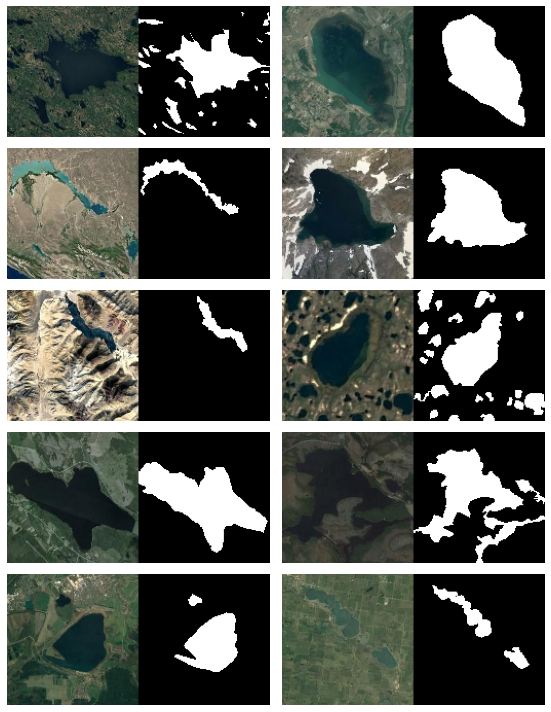

In [0]:
show_combined_plots(img, msk, BATCH_SIZE, (8, 10))

## UNet model

IoU calculation

In [0]:
def mean_iou_imp(y_true, y_pred):
  i = backend.sum(backend.abs(y_true*y_pred), axis = -1)
  u = backend.sum(y_true, axis = -1) + backend.sum(y_pred, axis = -1) - i
  iou = backend.mean((i+1)/(u+1), axis = 0)
  return iou

UNet implementation

In [0]:
class unet():
    def __init__(self):
        inputs = Input((TARGET_HEIGHT, TARGET_HEIGHT, 3))
        _tensor = inputs

        f = 64
        layers = []

        for i in range(0, 4):
            _tensor = Conv2D(f, 3, activation = 'relu', padding = 'same')(_tensor)
            _tensor = Conv2D(f, 3, activation = 'relu', padding = 'same')(_tensor)
            layers.append(_tensor)
            _tensor = MaxPooling2D()(_tensor)
            f = f*2

        ff2 = 1024
        j = len(layers)-1
        _tensor = Conv2D(f, 3, activation = 'relu', padding = 'same')(_tensor)
        _tensor = Conv2D(f, 3, activation = 'relu', padding = 'same')(_tensor)
        _tensor = Conv2DTranspose(ff2, 2, strides = (2, 2), padding = 'same')(_tensor)
        
        _tensor = Concatenate(axis = 3)([_tensor, layers[j]])
        j = j-1
  
        for i in range(0, 3):
            ff2 = ff2//2
            f = f//2
            _tensor = Conv2D(f, 3, activation = 'relu', padding = 'same')(_tensor)
            _tensor = Conv2D(f, 3, activation = 'relu', padding = 'same')(_tensor)
            _tensor = Conv2DTranspose(ff2, 2, strides = (2, 2), padding = 'same')(_tensor)
            _tensor = Concatenate(axis = 3)([_tensor, layers[j]])          
            j = j - 1

        _tensor = Conv2D(f, 3, activation = 'relu', padding = 'same')(_tensor)
        _tensor = Conv2D(f, 3, activation = 'relu', padding = 'same')(_tensor)
 
        outputs = Conv2D(1, 1, activation = 'sigmoid')(_tensor)
 
        self._model = Model(inputs, outputs)
        self._model.compile(optimizer='adam', 
                            loss='binary_crossentropy',
                            metrics = [mean_iou_imp])

    def train(self, train_gen, test_gen, batch, e, steps, vsteps, callbacks):
      self.history = self._model.fit(train_gen,
                                     verbose = 1,
                                     callbacks = callbacks,
                                     validation_data = test_gen,
                                     batch_size = batch,
                                     epochs = e,
                                     steps_per_epoch = steps,
                                     validation_steps = vsteps
                                     )

In [0]:
unet_model = unet()

Model summary

In [0]:
unet_model._model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

## Training with NWPU data

In [0]:
pickle_path = working_dir + 'nwpu_unet_model.h5'
nwpu_logs_dir = working_dir + 'logs/fit/nwpu/'

In [0]:
epoch = 20
steps_per_epoch = 10
vsteps = 10

checkpoint = ModelCheckpoint(pickle_path, 
                             monitor = 'val_loss', 
                             mode = 'min', 
                             verbose = 1, 
                             save_best_only = True)

early_stop_condition = EarlyStopping(monitor = 'val_loss', 
                                     mode = 'min',
                                     verbose = 1, 
                                     patience = 3)

tboard = TensorBoard(log_dir = nwpu_logs_dir)

cb = [early_stop_condition, checkpoint, tboard]

In [0]:
%%time
unet_model.train(train_generator, test_generator, 
                 BATCH_SIZE, 
                 epoch, steps_per_epoch, vsteps, 
                 cb)

Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 0.5172 - mean_iou_imp: 0.7773 
Epoch 00001: val_loss improved from inf to 0.39883, saving model to drive/My Drive/Colab_Live_Project_Surface_Water/unet_model.h5
10/10 [==============================] - 278s 28s/step - loss: 0.5172 - mean_iou_imp: 0.7773 - val_loss: 0.3988 - val_mean_iou_imp: 0.8503
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 0.4246 - mean_iou_imp: 0.8351 
Epoch 00002: val_loss improved from 0.39883 to 0.33169, saving model to drive/My Drive/Colab_Live_Project_Surface_Water/unet_model.h5
10/10 [==============================] - 274s 27s/step - loss: 0.4246 - mean_iou_imp: 0.8351 - val_loss: 0.3317 - val_mean_iou_imp: 0.8417
Epoch 3/20
10/10 [==============================] - ETA: 0s - loss: 0.2939 - mean_iou_imp: 0.8808 
Epoch 00003: val_loss improved from 0.33169 to 0.30273, saving model to drive/My Drive/Colab_Live_Project_Surface_Water/unet_model.h5
10/10 [====================

Utility method to call predict and show the outcome 

In [0]:
def show_prediction(m, gen):
  X_test, y_test = next(gen)
  y_pred = m._model.predict(X_test)
  show_combined_plots(X_test, y_pred, BATCH_SIZE, (8, 10))

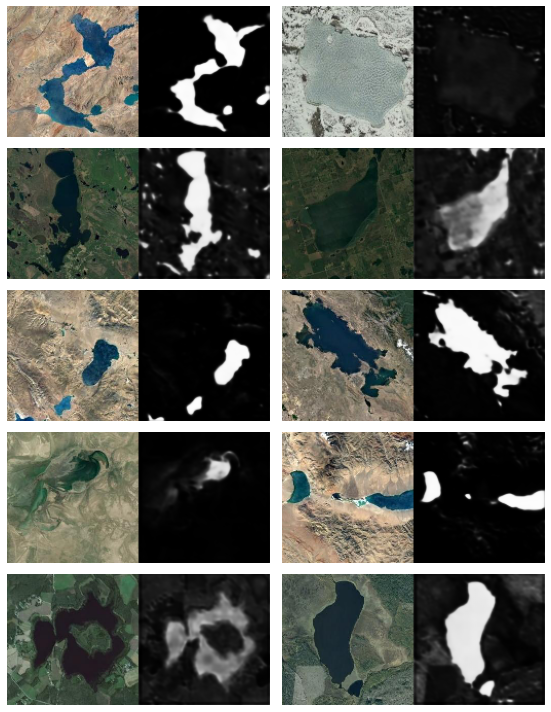

In [0]:
show_prediction(unet_model, test_generator)

In [0]:
unet_model.history.history.keys()

dict_keys(['loss', 'mean_iou_imp', 'val_loss', 'val_mean_iou_imp'])

History plot for loss and IoU



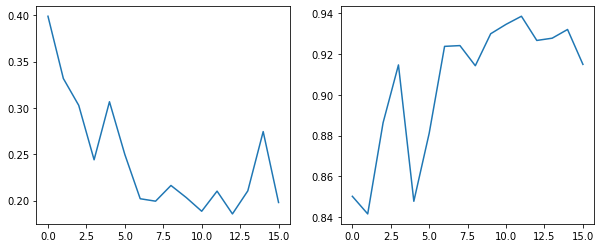

In [0]:
_, axs = plt.subplots(1,2, figsize = (10, 4))
axs[0].plot(unet_model.history.history['val_loss'])
axs[1].plot(unet_model.history.history['val_mean_iou_imp'])

In [0]:
history_path_nwpu = working_dir + 'nwpu_history.json'
with open(history_path_nwpu, 'w') as nwpuhist:
  json.dump(unet_model.history.history, nwpuhist)

In [0]:
pickle_path = 'drive/My Drive/Colab_Live_Project_Surface_Water/nwpu_unet_model.h5'

In [0]:
restored_unet = unet()
restored_unet._model.load_weights(pickle_path)

### Testing NWPU trained network on S2 data

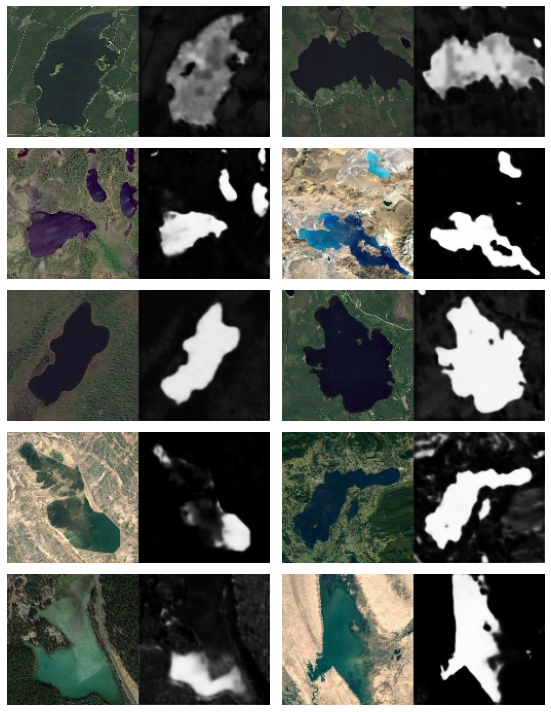

In [0]:
restored_unet
show_prediction(restored_unet, test_generator)

In [0]:
%tensorboard --logdir '{nwpu_logs_dir}'

<IPython.core.display.Javascript object>

In [0]:
s2_input_images_dir = image_dir + 'S2_Cloudless/Train/Images/'
s2_input_masks_dir = image_dir + 'S2_Cloudless/Train/Masks/'
s2_test_images_dir = image_dir + 'S2_Cloudless/Test/Images/'
s2_test_masks_dir = image_dir + 'S2_Cloudless/Test/Masks/'

In [0]:
s2_train_generator, s2_test_generator = create_generators_for_input(
                                          s2_input_images_dir, 
                                          s2_input_masks_dir, 
                                          s2_test_images_dir, 
                                          s2_test_masks_dir
                                          )

Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
Found 10 images belonging to 1 classes.
Found 10 images belonging to 1 classes.


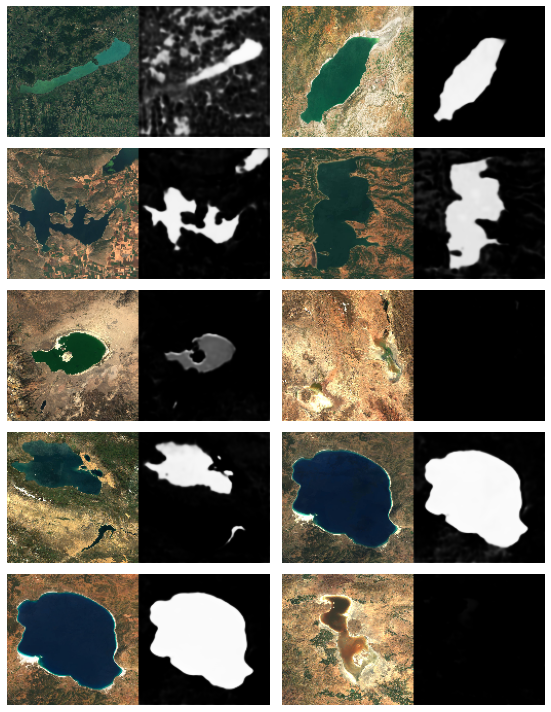

In [0]:
show_prediction(restored_unet, s2_test_generator)

## Training on S2 data

In [0]:
s2_pickle_path = working_dir + 's2_unet_model.h5'
s2_logs_dir = working_dir + 'logs/fit/s2/'

In [0]:
epoch = 20
steps_per_epoch = 10
vsteps = 10

s2_unet_model = unet()

checkpoint = ModelCheckpoint(s2_pickle_path, 
                             monitor = 'val_loss', 
                             mode = 'min', 
                             verbose = 1, 
                             save_best_only = True)

early_stop_condition = EarlyStopping(monitor = 'val_loss', 
                                     mode = 'min',
                                     verbose = 1, 
                                     patience = 3)

s2_tboard = TensorBoard(log_dir = s2_logs_dir)

cb = [early_stop_condition, checkpoint, s2_tboard]

In [0]:
%%time
s2_unet_model.train(s2_train_generator, s2_test_generator, 
                 BATCH_SIZE, 
                 epoch, steps_per_epoch, vsteps, 
                 cb)

Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 0.4218 - mean_iou_imp: 0.8312 
Epoch 00001: val_loss improved from inf to 0.37651, saving model to drive/My Drive/Colab_Live_Project_Surface_Water/s2_unet_model.h5
10/10 [==============================] - 354s 35s/step - loss: 0.4218 - mean_iou_imp: 0.8312 - val_loss: 0.3765 - val_mean_iou_imp: 0.8572
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 0.3091 - mean_iou_imp: 0.8763 
Epoch 00002: val_loss improved from 0.37651 to 0.34408, saving model to drive/My Drive/Colab_Live_Project_Surface_Water/s2_unet_model.h5
10/10 [==============================] - 352s 35s/step - loss: 0.3091 - mean_iou_imp: 0.8763 - val_loss: 0.3441 - val_mean_iou_imp: 0.8535
Epoch 3/20
10/10 [==============================] - ETA: 0s - loss: 0.2935 - mean_iou_imp: 0.8840 
Epoch 00003: val_loss improved from 0.34408 to 0.31771, saving model to drive/My Drive/Colab_Live_Project_Surface_Water/s2_unet_model.h5
10/10 [===========

### Metric plots for both NWPU and S2 training

In [0]:
with open(history_path_nwpu) as nwpu_restored_history:
  unet_history = json.load(nwpu_restored_history)

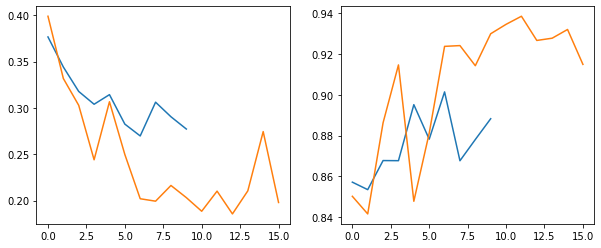

In [0]:
_, axs = plt.subplots(1,2, figsize = (10, 4))
axs[0].plot(s2_unet_model.history.history['val_loss'])
axs[0].plot(unet_history['val_loss'])

axs[1].plot(s2_unet_model.history.history['val_mean_iou_imp'])
axs[1].plot(unet_history['val_mean_iou_imp'])

In [0]:
history_path_s2 = working_dir + 's2_history.json'
with open(history_path_s2, 'w') as s2hist:
  json.dump(s2_unet_model.history.history, s2hist)

### Testing

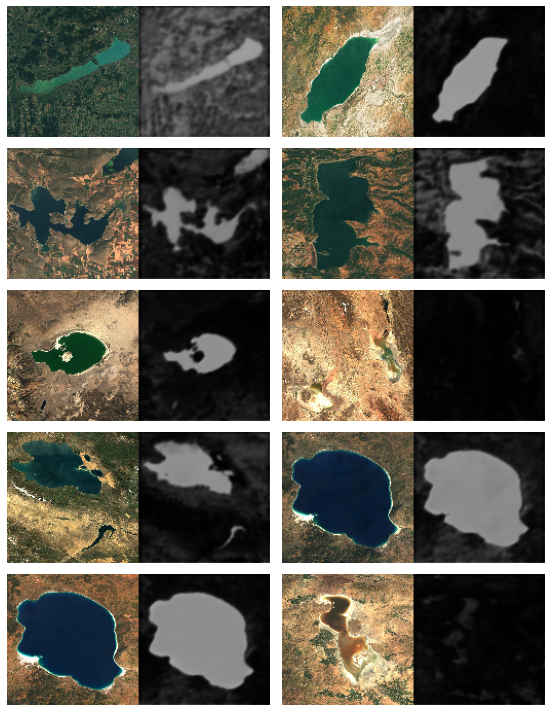

In [0]:
show_prediction(s2_unet_model, s2_test_generator)